# Data Extraction

In [5]:
import gzip
import pandas as pd

def parse(filename):
  f = gzip.open(filename, 'rt', encoding='utf-8')
  entry = {}
  for l in f:
    l = l.strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry

reviews = pd.DataFrame(list(parse("data/Cell_Phones_&_Accessories.txt.gz")))
reviews.columns = [
    "product_id", "product_title", "product_price",
    "user_id", "profile_name", "helpfulness",
    "score", "time", "summary", "text"
]

reviews = reviews.astype({
  "product_id": str,
  "product_title": str,
  "user_id": str,
  "profile_name": str,
  "helpfulness": str,
  "score": float,
  "summary": str,
  "text": str,
})

reviews["product_price"] = pd.to_numeric(reviews["product_price"], errors="coerce").astype("float64") 
reviews["time"] = pd.to_numeric(reviews["time"], errors="coerce").astype("Int64") 

# Data Preprocessing

Dataset includes 78 931 samples.

In [6]:
print(reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78931 entries, 0 to 78930
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     78931 non-null  object 
 1   product_title  78931 non-null  object 
 2   product_price  35643 non-null  float64
 3   user_id        78931 non-null  object 
 4   profile_name   78931 non-null  object 
 5   helpfulness    78931 non-null  object 
 6   score          78930 non-null  float64
 7   time           78930 non-null  Int64  
 8   summary        78931 non-null  object 
 9   text           78931 non-null  object 
dtypes: Int64(1), float64(2), object(7)
memory usage: 6.1+ MB
None


In [7]:
print(reviews.head().to_markdown())

|    | product_id   | product_title                                                                                                                                                                                 |   product_price | user_id        | profile_name                       | helpfulness   |   score |       time | summary                                                   | text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Let's drop duplicates and find users, which have unknown ID

In [8]:
no_dupes = reviews.drop_duplicates()
unknow_users = no_dupes[no_dupes['user_id'] == 'unknown']
print(len(unknow_users))
cleaned_users = no_dupes[no_dupes['user_id'] != 'unknown']

2274


Here we are looking for users, which left multiple reviews in one product. We will keep only the most recent ones 

In [9]:
sorted_reviews = cleaned_users.sort_values(by=['user_id', 'product_id', 'time'], ascending=[True, True, False])
cleaned_df = sorted_reviews.drop_duplicates(subset=['user_id', 'product_id'], keep='first')
print(len(cleaned_df))
print(cleaned_df.iloc[:10].to_markdown())

76416
|       | product_id   | product_title                                                                                                                                                                             |   product_price | user_id               | profile_name    | helpfulness   |   score |       time | summary                                        | text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
|------:|:-------------|:----------------------------------------------------------------------------------------------------------------------

Now it is a time for a price column, as we can see, the number of unknown price is very large (more than 50% of the whole data), so let's keep it as it is. 

In [10]:
unknown_price = cleaned_df[cleaned_df['product_price'] == 'unknown']
print(len(unknown_price))

0


# Exploratory Data Analysis

In [60]:
! pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached matplotlib-3.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
  Using cached fonttools-4.56.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
  Using cached contourpy-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (324 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached pillow-11.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (4.5 MB)


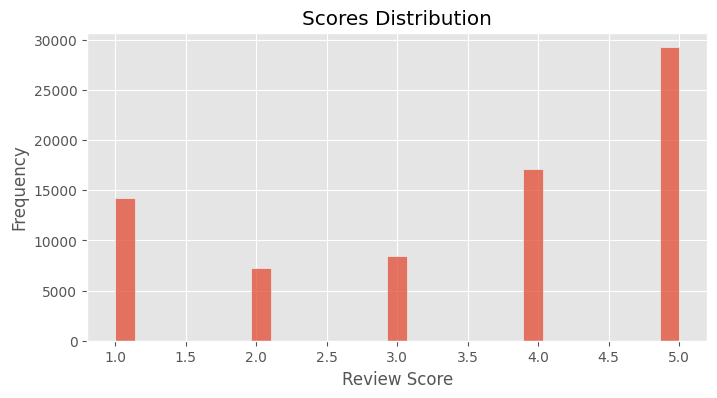

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

sorted_scores = cleaned_df.sort_values(by='score', ascending=True)
plt.figure(figsize=(8, 4))
sns.histplot(sorted_scores['score'])
plt.title("Scores Distribution")
plt.xlabel("Review Score")
plt.ylabel("Frequency")
plt.show()

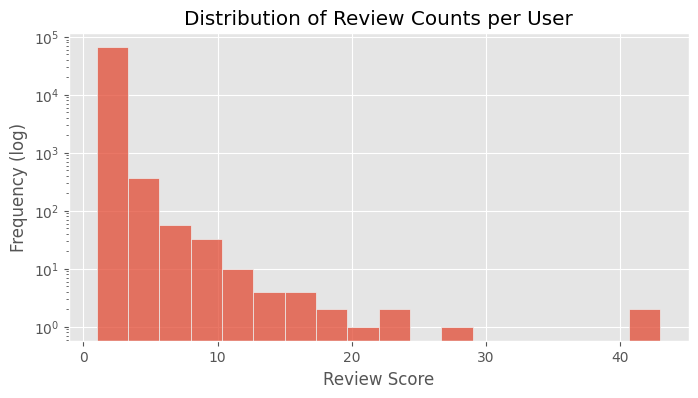

In [12]:
user_reviews = cleaned_df.groupby(by='user_id')['user_id'].count()
user_reviews = user_reviews.sort_values(ascending=True)

plt.figure(figsize=(8, 4))
sns.histplot(user_reviews)
plt.title("Distribution of Review Counts per User")
plt.ylabel("Frequency (log)")
plt.xlabel("Review Score")
plt.yscale('log')
plt.show()

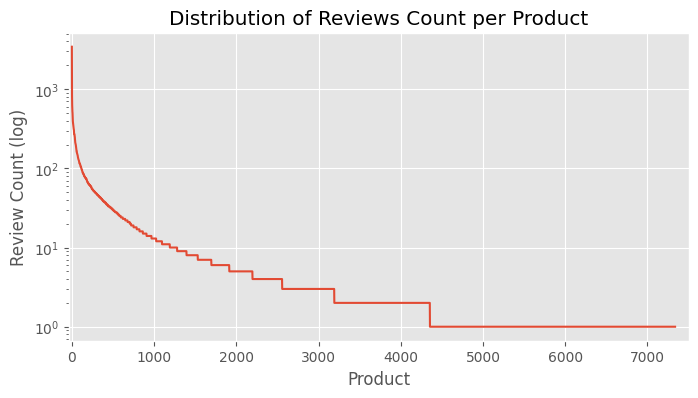

In [13]:
product_reviews = cleaned_df.groupby(by='product_id')['product_id'].count()
product_reviews = product_reviews.sort_values(ascending=False)

plt.figure(figsize=(8, 4))
plt.plot(product_reviews.values)
plt.xlim(-40, 7500)
plt.yscale('log')
plt.title("Distribution of Reviews Count per Product")
plt.xlabel("Product")
plt.ylabel("Review Count (log)")
plt.show()

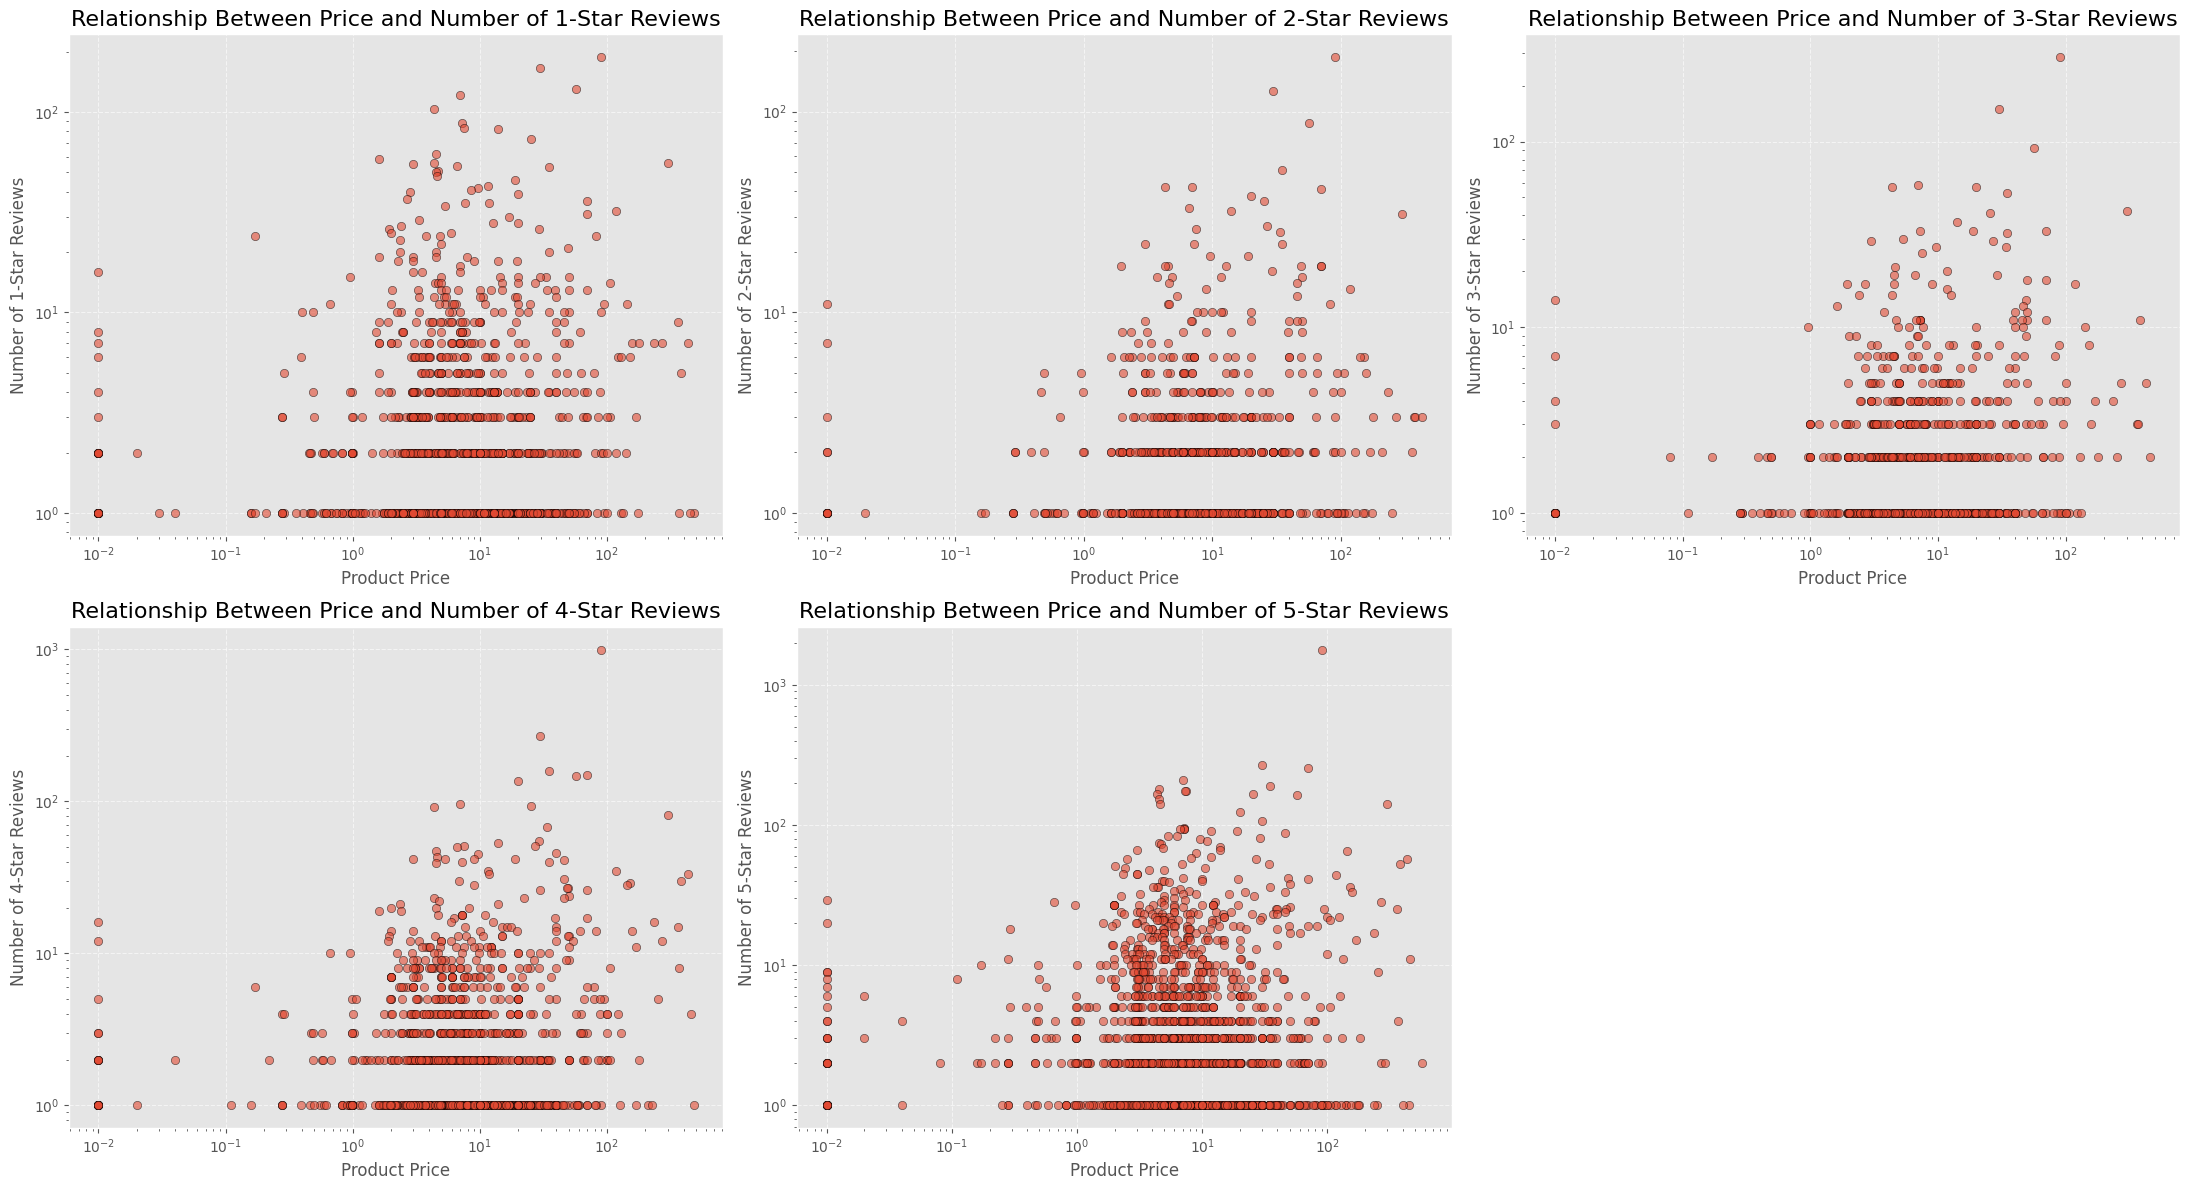

In [16]:
transformed_df = cleaned_df[cleaned_df['product_price'] != 'unknown']
price_info = cleaned_df[['product_id', 'product_price']].drop_duplicates()

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()

for i, score in enumerate([1.0, 2.0, 3.0, 4.0, 5.0]):
    only_one_score = transformed_df[transformed_df['score'] == score]
    only_one_score = only_one_score.groupby(by='product_id').size().reset_index(name='count')
    merged_df = pd.merge(price_info, only_one_score, 'right', 'product_id')
    merged_df = merged_df.sort_values(by='count', ascending=False)

    sns.scatterplot(data=merged_df, x='product_price', y='count', alpha=0.6, edgecolor='k', ax=axes[i])

    axes[i].set_title(f"Relationship Between Price and Number of {int(score)}-Star Reviews", fontsize=16)
    axes[i].set_xlabel("Product Price", fontsize=12)
    axes[i].set_ylabel(f"Number of {int(score)}-Star Reviews", fontsize=12)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].grid(True, linestyle='--', alpha=0.6)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

In [222]:
print(cleaned_df.iloc[:10].to_markdown())

|       | product_id   | product_title                                                                                                                                                                             | product_price   | user_id               | profile_name    | helpfulness   |   score |       time | summary                                        | text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
|------:|:-------------|:----------------------------------------------------------------------------------------------------------------------------

In [35]:
import importlib
import sentiment
import config 

importlib.reload(sentiment)
importlib.reload(config)

from sentiment import SentimentAnalysis
from config import BaseConfig as config

example = cleaned_df.iloc[:50]

sentiment_analysis = SentimentAnalysis(config.DEVICE, config.SENTIMENT_MODEL, example)
results = sentiment_analysis.predict()

Processing batches: 100%|██████████| 4/4 [00:08<00:00,  2.17s/batch]


In [36]:
print(results.to_markdown())

|    | product_id   | product_title                                                                                                                                                                                                                                                   |   product_price | user_id               | profile_name                         | helpfulness   |   score |       time | summary                                                     | text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      